In [28]:
import dyPolyChord.python_likelihoods as likelihoods  # Import some example python likelihoods
import dyPolyChord.python_priors as priors  # Import some example python priors
import dyPolyChord.pypolychord_utils
import dyPolyChord
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.special import ndtri
from scipy.stats import gamma, uniform
from scipy.linalg import cholesky, LinAlgError, eigvalsh, eigh, inv
from scipy.special import gamma as gamma_func
from scipy.special import kv
import time
from tqdm.notebook import tqdm

%matplotlib notebook

def f(x):
    """The function to predict."""
    return x * np.sin(x)

def rbf(theta,x):
    
    return theta[0]**2 * np.exp(-0.5 * theta[1]**-2 * np.subtract.outer(x,x)**2)

def periodic(theta,x):
    
    return theta[0]**2 * np.exp(-2 * theta[1]**-2 * np.sin(np.pi * np.subtract.outer(x,x) / theta[2])**2)

def local_periodic(theta,x):
    
    return rbf(theta,x) * periodic(theta,x)

def matern(theta, x):

    u = np.sqrt(2 * theta[0]) * abs(np.subtract.outer(x,x) / theta[1])
    u[u == 0.0] += np.finfo(float).eps
    K = 2**(1-theta[0]) / gamma_func(theta[0]) * (u)**theta[0] * kv(theta[0], u)

    return K
    
def GP(kernel, theta, data, mu_prior=[], sigma=[]):
    
    global K_XX_error
    
    # Define test points (XT) and training data (X, y)
    XT, X, y = data
    n = len(X)
    
    # Calculate cov. matrix for join distribution
    K = kernel(theta, np.concatenate((X, XT)))
    
    # For non-noisy training data set sigma = 0
    if len(sigma)==0:
        sigma = np.zeros(n)
    if len(mu_prior)==0:
        mu_prior = np.zeros(n)
    
    # Sub-matrices of joint distribution, using cholesky decomp. for inversion
    K_XTX = K[n:,:n]
    K_XX = K[:n,:n]+np.diag(sigma**2)
    try:
        ch_K_XX = cholesky(K_XX, lower=True)#+np.diag(np.ones(len(K_XX)))*1E-10, lower=True)
    except:
        display(theta)
        display(K_XX)
        display(eigvalsh(K_XX))
        K_XX_error = K_XX
        
    K_XX_inv = inv(ch_K_XX.T) @ inv(ch_K_XX)#inv(K[:n,:n]+np.diag(sigma**2))
    K_XXT = K[:n,n:]
    K_XTXT = K[n:,n:]
    
    # Find conditioned mean function and covariance matrix
    m = K_XTX @ K_XX_inv @ (y-mu_prior)
    K = K_XTXT - K_XTX @ K_XX_inv @ K_XXT
    
    return (m, np.sqrt(np.diag(K)))


In [29]:
X = np.arange(0,15,0.5)
XT = np.arange(0, X[-1]+1,0.01)
dy= 0.5
y = f(X) + np.random.normal(scale=dy, size=len(X))
sigma = np.ones(len(y))*dy

GP runtime for 30 samples: 0.7015533447265625 s


<IPython.core.display.Javascript object>


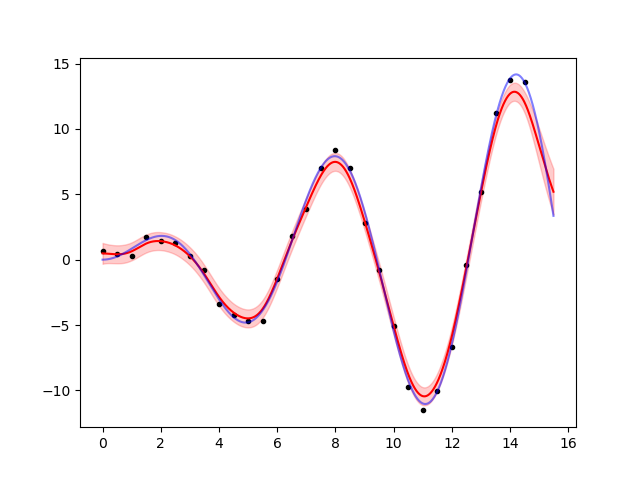

In [33]:
def prior_transform(theta):

    return gamma.ppf(theta,5.5)

def loglikelihood(theta):
    
    # Define global variables
    global X,y,sigma
    data_tmp = (X[1::2],X[::2],y[::2])
    sigma_training = sigma[::2]
    y_test = y[1::2]
    sigma_test = sigma[1::2]

    # normalisation
    norm = -0.5*len(data_tmp[0])*np.log(2*np.pi) - np.sum(np.log(sigma_test))

    # chi-squared
    chisq = np.sum(((y_test-GP(rbf, theta, data_tmp, sigma=sigma_training)[0])/sigma_test)**2)

    return norm - 0.5*chisq, []

data_tmp = (XT,X,y)
theta = [5/2,1]

t0 = time.time()
gp = GP(matern, theta, data_tmp, sigma=sigma)
print('GP runtime for %s samples: %s s' %(len(X), time.time()-t0))
plt.figure()
plt.plot(X, y, 'k.')
plt.plot(XT, gp[0], c='r')
plt.fill_between(XT, gp[0]+gp[1]*2, gp[0]-gp[1]*2, color='r', alpha=0.2)
plt.plot(XT, f(XT), c='b',alpha=0.5)

In [5]:
ndim = 2
# Make a callable for running PolyChord
my_callable = dyPolyChord.pypolychord_utils.RunPyPolyChord(
    loglikelihood, prior_transform, ndim)

# Specify sampler settings (see run_dynamic_ns.py documentation for more details)
dynamic_goal = 1.0  # whether to maximise parameter estimation or evidence accuracy.
ninit = 100          # number of live points to use in initial exploratory run.
nlive_const = 500   # total computational budget is the same as standard nested sampling with nlive_const live points.
settings_dict = {'file_root': 'gaussian',
                 'base_dir': 'chains',
                 'seed': 1,
                 'precision_criterion': 0.01}

In [6]:
t0 = time.time()
dyPolyChord.run_dypolychord(my_callable, dynamic_goal, settings_dict, ninit=ninit, 
                            nlive_const=nlive_const, seed_increment=5)
print("Time taken to run 'PyPolyChord' is {} seconds".format(time.time()-t0))

Done with initial run: 52.67106056213379 s
Done with live point allocation: 0.03879690170288086 s
Time taken to run 'PyPolyChord' is 431.3258514404297 seconds


In [7]:
import nestcheck.data_processing
import nestcheck.estimators as e
from math import log10, floor

def round_sig(x, sig=1):
    """
    Rounds a float to the given number of significant
    figures.
    
    Parameters
    -------------
    x    : Float
           Float to be rounded
    sig  : Integer
           Number of sig. figures
    """
    
    i = sig-int(floor(log10(abs(x))))-1
    return np.around(x, i), i

# load the run
run = nestcheck.data_processing.process_polychord_run(
    'gaussian',  # = settings['file_root']
    'chains')    # = settings['base_dir']

err = nestcheck.error_analysis.run_std_bootstrap(run, [e.logz], n_simulate=100)[0]
err, i = round_sig(err)
z_est = np.around(e.logz(run),i)

print('The log evidence estimate using the first run is %s +- %s'
      %(z_est, err))
#print('The estimated the mean of the first parameter is {}'
#      .format(e.param_mean(run, param_ind=1)))

The log evidence estimate using the first run is -20.4 +- 0.2


Number of posterior samples is 3291


<IPython.core.display.Javascript object>


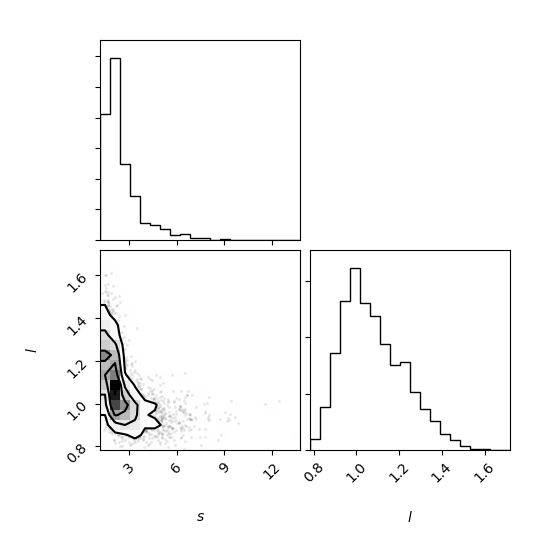

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [8]:
import corner

def plotposts(samples, **kwargs):
    """
    Function to plot posteriors using corner.py and scipy's gaussian KDE function.
    """
    
    fig = corner.corner(samples, labels=[r'$s$', r'$l$', r'$p$'], hist_kwargs={'density': True}, **kwargs)

broot = settings_dict['base_dir'] + '/' + settings_dict['file_root']
samplefile = broot+'_equal_weights.txt'
samples_polychord = np.loadtxt(samplefile)
samples_polychord = samples_polychord[:,-ndim:] # extract the last 'ndims' columns

resdict = {}
# print out the number of posterior samples
print('Number of posterior samples is {}'.format(samples_polychord.shape[0]))

resdict['s_mu'] = np.mean(samples_polychord[:,0])      # mean of s samples
resdict['s_sig'] = np.std(samples_polychord[:,0])      # standard deviation of s samples
resdict['l_mu'] = np.mean(samples_polychord[:,1])      # mean of l samples
resdict['l_sig'] = np.std(samples_polychord[:,1])      # standard deviation of l samples
#resdict['p_mu'] = np.mean(samples_polychord[:,2])      # mean of p samples
#resdict['p_sig'] = np.std(samples_polychord[:,2])      # standard deviation of p samples
resdict['cc'] = np.corrcoef(samples_polychord.T)[0,1]  # correlation coefficient between parameters
resdict['npos'] = len(samples_polychord)              # number of posterior samples
#resdict['time'] = timepolychord                       # run time
#resdict['logZ'] = output.logZ                         # log marginalised likelihood
#resdict['logZerr'] = output.logZerr                   # uncertainty on log(Z)

%matplotlib notebook
# plot using corner.py
plotposts(samples_polychord)

from IPython.display import display, Math

labels = ['s', 'l']

for i in range(2):
    mcmc = np.percentile(samples_polychord[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

## Emcee and direct sampling

In [10]:
import emcee as em
from math import log10, floor



def logprior(theta):
    
    """Prior on s and l. Assuming independent priors, so total prior is product of priors for s and l"""
    
    return np.sum(gamma.logpdf(theta,5.5))

def matern_logprior(theta):

    nu, l = theta

    return gamma.logpdf(nu, 5/2) + gamma.logpdf(l, 4.5, loc=150)

def matern_inisamples(Nens):

    return np.vstack((gamma.rvs(5/2, size=Nens),gamma.rvs(4.5, loc=150, size=Nens))).T


def loglikelihood(theta, data, kernel=rbf):
    
    """Data has structure (XT, X, y, yT, sigmaT, sigma)"""
    # Define global variables

    # normalisation
    norm = -0.5*len(data[0])*np.log(2*np.pi) - np.sum(np.log(data[4]))

    # chi-squared
    chisq = np.sum(((data[3]-GP(kernel, theta, data[:3], sigma=data[5])[0])/data[4])**2)

    return norm - 0.5*chisq

def logposterior(theta, data, kernel=rbf):
    
    lp = matern_logprior(theta)
    
    if not np.isfinite(lp):
        
        return -np.inf
    
    return lp + loglikelihood(theta, data, kernel=kernel)

In [6]:
data = (X[1::2],X[::2],y[::2],y[1::2],sigma[1::2],sigma[::2])

In [22]:
n = 10000
r = uniform.rvs(size=(n,2))
theta_samples = gamma.ppf(r, 5.5)

likelihood_vals = np.zeros(n)

for i in tqdm(range(n)):

    likelihood_vals[i] = np.exp(loglikelihood(theta_samples[i], data))
#    delta = likelihood_vals[i]-np.exp(loglikelihood(theta_samples[i]))

Z = 1/n*np.sum(likelihood_vals)
Z_sq = 1/n*np.sum(likelihood_vals**2)

Z_err, i = round_sig(np.sqrt(Z_sq-Z**2)/(np.sqrt(n)*Z))
Z_val = np.around(np.log(Z), i)

print('Log evidence estimate using direct sampling from the prior: %s +- %s'
      %(Z_val, Z_err))


Log evidence estimate using direct sampling from the prior: -21.1 +- 0.3


In [8]:
Nens = 100   # number of ensemble points
ndims = 2    # Number of dimensions
inisamples = matern_inisamples(Nens)#gamma.rvs(5.5, size=(Nens, ndims)) # Initial samples

Nburnin = 500   # number of burn-in samples
Nsamples = 500  # number of final posterior samples

In [11]:
print('emcee version: {}'.format(em.__version__))

# set additional args for the posterior (the data, the noise std. dev., and the abscissa)
argslist = (data, matern)

# set up the sampler
sampler = em.EnsembleSampler(Nens, ndims, logposterior, args=argslist)

emcee version: 3.0.0


In [12]:
# pass the initial samples and total number of samples required
t0 = time.time() # start time
sampler.run_mcmc(inisamples, Nsamples+Nburnin, progress=True);
t1 = time.time()

timeemcee = (t1-t0)
print("Time taken to run 'emcee' is {} seconds".format(timeemcee))

# extract the samples (removing the burn-in)
samples_emcee = sampler.chain[:, Nburnin:, :].reshape((-1, ndims))

100%|██████████| 1000/1000 [01:26<00:00, 11.53it/s]

Time taken to run 'emcee' is 86.87542080879211 seconds


N/50 = 20;
tau: [13.84339055 28.73956212]


The autocorrelation length for m is 13.843390547429026 and c is 28.739562124173197
Number of independent samples is 1800


<IPython.core.display.Math object>

<IPython.core.display.Math object>

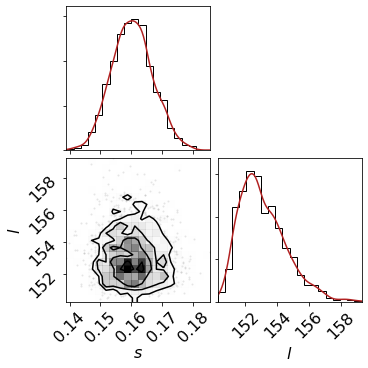

In [13]:
import matplotlib as mpl
import corner
from scipy.stats import gaussian_kde
# plot the resulting posteriors
mpl.rcParams.update({'font.size': 16})

#def plotposts(samples, truths=[m,c]):
def plotposts(samples, **kwargs):
    """
    Function to plot posteriors using corner.py and scipy's gaussian KDE function.
    """
    
    fig = corner.corner(samples, labels=[r'$s$', r'$l$'], hist_kwargs={'density': True}, **kwargs)

    # plot KDE smoothed version of distributions
    for axidx, samps in zip([0, 3], samples.T):
        kde = gaussian_kde(samps)
        xvals = fig.axes[axidx].get_xlim()
        xvals = np.linspace(xvals[0], xvals[1], 100)
        fig.axes[axidx].plot(xvals, kde(xvals), color='firebrick')

s_acl, l_acl = sampler.get_autocorr_time(c=1, quiet=True)
print("The autocorrelation length for m is {0} and c is {1}".format(s_acl, l_acl))

# thin out the chain
samples_emcee = sampler.chain[:, Nburnin::int(max([s_acl, l_acl])), :].reshape((-1, ndims))
print("Number of independent samples is {}".format(len(samples_emcee)))

# plot the resulting posteriors
plotposts(samples_emcee)

from IPython.display import display, Math

labels = ['nu', 'l']

for i in range(ndims):
    mcmc = np.percentile(samples_emcee[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

In [ ]:
K = dists
K[K == 0.0] += np.finfo(float).eps  # strict zeros result in nan
tmp = (math.sqrt(2 * nu) * K)
K.fill((2 ** (1. - nu)) / gamma_func(nu))
K *= tmp ** self.nu
K *= kv(self.nu, tmp)